In [62]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [217]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"


unpopular_vineScores = "../Logs/MVSO_fine_vine_unpopular_probs.csv"
vineScores = "../Logs/MVSO_fine_vine_probs.csv"

#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
unpop_vineANPs = "../Logs/MVSO_fine_vine_unpopular_ANPs.pk"

pop_vineANPs = "../Logs/MVSO_fine_vine_ANPs.pk"
#selfiePaths = "../Logs/selfiePaths.txt"


#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

postFile = "../Logs/postsMapping.csv"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

savedSentiments = "../Logs/sentimentsSaved.csv"

In [64]:
unpopular_vineProbs = np.loadtxt(unpopular_vineScores, delimiter=',')
print unpopular_vineProbs.shape

(36661, 4342)


In [ ]:
#Load the Sentibank scores for Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')
print vineProbs.shape

In [80]:
print vineProbs.shape

(138256, 4342)


In [65]:
class UnpopularVids:
    
    def get_ANP_ID_List(self , pickleList , nameIdx):
        ANPs = []
        IDs = []
        for line in pickleList:
            ids = line.split(',')[0].split('/')[nameIdx].split('_')[0]
            IDs.append(ids)
            ANPs.append(line.split(',')[1])
        return IDs , ANPs

    def get_vid_senti(self , pickle , index , nameidx):
        oldId = pickle[index].split(',')[0].split('/')[nameidx].split('_')[0]
        seqDict = dict()
        indexList = []
        sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index+=1
        #print index
        while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[nameidx].split('_')[0] == oldId)):
            sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
            seqDict[int(sequence)] = str(pickle[index].split(',')[1])
            indexList.append(index)
            index += 1
        seqDict['indexList'] = indexList
        return seqDict , oldId , index

    #This function maps each video with a dictionary entry that has list of all ANPS per frame
    #and an index list to find them
    def get_VID_ANP_List(self , pickle, nameidx):
        megaDict = dict()
        i = 0
        print len(pickle)
        while i < len(pickle):           
            subDict , postId , i = get_vid_senti(pickle , i , nameidx)
            megaDict[int(postId)] = subDict
        return megaDict


    def pruneMegaDict(self , megadict , filterindices):
        filteredList = dict()
        for entry in megadict:
            commns = set(megadict[entry]['indexList']).intersection(filterindices)
            if len(commns) >= 6:
                filteredList[entry] = megadict[entry]
        return filteredList

    def readJson(self , path):
        f = open(path)
        data = json.loads(f.read())
        return data


In [235]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines

def readAesFeatuers(lines):
    features = []
    for line in lines:
        components = line.strip().split('|')
        features.append([float(x) for x in components[1:]])
    return features

def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            median = np.median(feats,0)
            for i in range(len(median)):
                if np.isnan(median[i]):
                    median[i] = 0.0
            features.append(median)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [66]:
class PopularVids:
    def get_ANP_ID_List(self , pickleList , nameIdx):
        ANPs = []
        IDs = []
        for line in pickleList:
            ids = line.split(',')[0].split('/')[nameIdx].split('_')[0]
            IDs.append(ids)
            ANPs.append(line.split(',')[1])
        return IDs , ANPs

    def get_vid_senti(self , pickle , index , nameidx):
        oldId = pickle[index].split(',')[0].split('/')[nameidx].split('_')[0]
        seqDict = dict()
        indexList = []
        sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index+=1
        #print index
        while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[nameidx].split('_')[0] == oldId)):
            sequence = pickle[index].split(',')[0].split('/')[nameidx].split('_')[1].split('.')[0]
            seqDict[int(sequence)] = str(pickle[index].split(',')[1])
            indexList.append(index)
            index += 1
        seqDict['indexList'] = indexList
        return seqDict , oldId , index

    #This function maps each video with a dictionary entry that has list of all ANPS per frame
    #and an index list to find them
    def get_VID_ANP_List(self , pickle, nameidx):
        megaDict = dict()
        i = 0
        print len(pickle)
        while i < len(pickle):           
            subDict , postId , i = get_vid_senti(pickle , i , nameidx)
            megaDict[int(postId)] = subDict
        return megaDict


    def pruneMegaDict(self , megadict , filterindices):
        filteredList = dict()
        for entry in megadict:
            commns = set(megadict[entry]['indexList']).intersection(filterindices)
            if len(commns) >= 6:
                filteredList[entry] = megadict[entry]
        return filteredList

    def readJson(self , path):
        f = open(path)
        data = json.loads(f.read())
        return data

In [67]:
class Similarity:
    def intersect(a, b):
        result=[]
        for i in b:
            if isinstance(i,list):
                result.append(intersect(a,i))
            else:
                if i in a:
                     result.append(i)
        return result

    def JaccardSim(l1 , l2):
        intersection = list(set(l1).intersection(l2))
        union = list(set(l1).union(l2))
        #intersection = intersect(l1 , l2)
        jaccard = float(len(intersection)/len(union))*1.0
        #jaccard = float(len(intersection)/(len(l1) + len(l2)))*1.0
        return jaccard

    def similarityMatrix(ANPList):
        simMatrix = np.zeros((len(ANPList),len(ANPList)))
        for i in range(len(ANPList)):
            for j in range(len(ANPList)):
                jacSim = JaccardSim(ANPList[i],ANPList[j])
                simMatrix[i][j] = jacSim
        return simMatrix

    def autocorr(x):
        result = np.correlate(x, x, mode='full')
        return result[result.size/2:]

    def findAutocorr(sentimatrix):
        autocorr_matrix = []
        for i in range(senti_matrix.shape[0]):
            autocorr_matrix.append(list(autocorr(senti_matrix[i])))
        return np.asarray(autocorr_matrix)
    
    

In [68]:

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

maxVecs = np.zeros(len(unpopular_vineProbs))
for i in range(len(unpopular_vineProbs)):
    maxVecs[i] = np.max(unpopular_vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

upObj = UnpopularVids()
popObj = PopularVids()

0.0221606246623 0.0150964222848 0.00101608409988


In [82]:
maxVecspop = np.zeros(len(vineProbs))
for i in range(len(vineProbs)):
    maxVecspop[i] = np.max(vineProbs[i])
print np.mean(maxVecspop) , np.median(maxVecspop) , np.var(maxVecspop)

0.0214652778476 0.0156120234169 0.000478212839106


In [87]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > (np.mean(maxVecspop))):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

44472


In [84]:
unpop_vineList = readLists(unpop_vineANPs)
pop_vineList = readLists(pop_vineANPs)
unpop_idList, unpop_anpList = upObj.get_ANP_ID_List(unpop_vineList , 5)
pop_idList, pop_anpList = popObj.get_ANP_ID_List(pop_vineList , 6)

In [71]:
print unpop_idList[1000] , unpop_anpList [1000]

1378092411129352192 modern_jive


In [85]:
megaDict_unpop = upObj.get_VID_ANP_List(unpop_vineList , 5)

36661


In [86]:
megaDict_pop = popObj.get_VID_ANP_List(pop_vineList , 6)

138256


In [88]:
filteredDict_pop = popObj.pruneMegaDict(megaDict_pop, curatedProbs_index)

In [89]:
postIds_unpop = []
for line in unpop_vineList:
    arr = line.split('/')
    i = int(arr[5].split('_')[0])
    postIds_unpop.append(i)

In [94]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [96]:
unpop_senti_matrix = np.zeros((len(megaDict_unpop),12))
ANP_matrix_unpop = list()
print unpop_senti_matrix.shape

i = 0
misses = 0
unpop_postIdFilteredList = []
for entry in megaDict_unpop:
    unpop_postIdFilteredList.append(entry)
    ANPEntry = list()
    for j in range(1,13):
        
        if j in megaDict_unpop[entry]:
            unpop_senti_matrix[i][j-1] = sentidict[megaDict_unpop[entry][j]] \
            if (megaDict_unpop[entry][j] in sentidict) \
            else sentidict[megaDict_unpop[entry][j-1]]
            
            ANPEntry.append(megaDict_unpop[entry][j])
        else:
            last = ANPEntry[-1]
            ANPEntry.append(last)
            unpop_senti_matrix[i][j-1] = senti_matrix[i][j-2]
            misses += 1
    ANP_matrix_unpop.append(ANPEntry)
    i += 1
print misses

(2999, 12)
2127


In [97]:
pop_senti_matrix = np.zeros((len(megaDict_pop),12))
ANP_matrix_pop = list()
print pop_senti_matrix.shape

i = 0
misses = 0
pop_postIdFilteredList = []
for entry in megaDict_pop:
    pop_postIdFilteredList.append(entry)
    ANPEntry = list()
    for j in range(1,13):
        
        if j in megaDict_pop[entry]:
            pop_senti_matrix[i][j-1] = sentidict[megaDict_pop[entry][j]] \
            if (megaDict_pop[entry][j] in sentidict) \
            else sentidict[megaDict_pop[entry][j-1]]
            
            ANPEntry.append(megaDict_pop[entry][j])
        else:
            last = ANPEntry[-1]
            ANPEntry.append(last)
            pop_senti_matrix[i][j-1] = pop_senti_matrix[i][j-2]
            misses += 1
    ANP_matrix_pop.append(ANPEntry)
    i += 1
print misses

(11449, 12)
4631


In [236]:
popular_color_features = "../Logs/vine_features_ordered.csv"
pop_features = readFeatureFile(popular_color_features)
popfeatures_matrix , popposts = readFeatures(pop_features)

50187


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 3 results
  RuntimeWarning)


In [239]:
print pop_postIdFilteredList[1]

1266437258970628096


In [237]:
commons = []
for i in popposts:
    if int(i) in pop_postIdFilteredList:
        commons.append(i)
        
    

0


In [229]:


s1 = np.random.choice(pop_senti_matrix.shape[0] , unpop_senti_matrix.shape[0])
sampled_pop_senti_matrix = pop_senti_matrix[s1,:]


senti_vector_unpop = np.mean(unpop_senti_matrix, axis = 1)
senti_vector_pop = np.mean(sampled_pop_senti_matrix, axis=1)
sampled_pop_posts = [pop_postIdFilteredList[i] for i in s1]


In [230]:
print len(sampled_pop_posts), len(unpop_postIdFilteredList)

2999 2999


In [231]:
saverPosts = np.asarray(sampled_pop_posts + unpop_postIdFilteredList , dtype='int')
print saverPosts.shape
saverMeanSentiments = np.concatenate((senti_vector_pop,senti_vector_unpop) ,axis = 0)
print saverMeanSentiments.shape
labels = np.concatenate((np.ones(len(sampled_pop_posts) , dtype='int'),np.zeros(len(unpop_postIdFilteredList),dtype='int')),axis = 0)
print labels.shape


(5998,)
(5998,)
(5998,)


In [232]:
# f = open(savedSentiments , 'a+')
# for i in range(len(saverPosts)):
#     logline = str(saverPosts[i]) + "," + str(labels[i]) + "," + str(saverMeanSentiments[i]) + "\n"
#     f.write(logline)
# f.close()

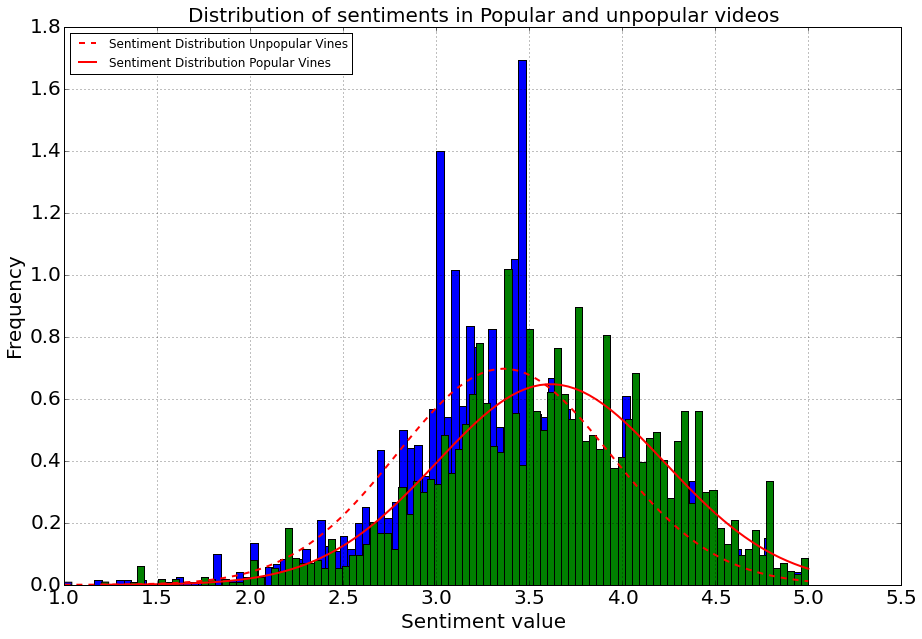

In [234]:
from scipy.stats import norm
import matplotlib.mlab as mlab

# best fit of data
(mu1, sigma1) = norm.fit(senti_vector_unpop)
(mu2, sigma2) = norm.fit(senti_vector_pop)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
n1 , bins1 , patches1 = plt.hist(senti_vector_unpop, 100, normed=1,histtype='bar', cumulative=False,linewidth = 1.0)
n2 , bins2 , patches2 = plt.hist(senti_vector_pop, 100, normed=1,histtype='bar', cumulative=False,linewidth = 1.0)

y1 = mlab.normpdf( bins1, mu1, sigma1)
l1 = plt.plot(bins1, y1, 'r--', linewidth=2)

y2 = mlab.normpdf( bins2, mu2, sigma2)
l2 = plt.plot(bins2, y2, 'r', linewidth=2)


#plt.plot(senti_vector_unpop)
#plt.plot(s1)

plt.title("Distribution of sentiments in Popular and unpopular videos", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.legend(['Sentiment Distribution Unpopular Vines' ,'Sentiment Distribution Popular Vines'], loc='upper left')
plt.grid()
plt.show()

In [149]:
def calculateMaxMinGraphs(senti_matrix):
    maxGraph = np.zeros(senti_matrix.shape[1])
    minGraph = np.zeros(senti_matrix.shape[1])
    varMaxGraph = np.zeros(senti_matrix.shape[1])
    varMinGraph = np.zeros(senti_matrix.shape[1])
    differenceList = []
    id1 = []
    id2 = []
    for i in range(len(senti_matrix)):
        a = max(senti_matrix[i])
        b = min(senti_matrix[i])
        median_sent = np.median(senti_matrix[i])
        diff = a - b

        diff2 = a - median_sent
        if diff > 0.5:
            ind1 = senti_matrix[i].tolist().index(a)
            if ind1 < 2:
                 id1.append(i)
            maxGraph[ind1] += 1
            ind2 = senti_matrix[i].tolist().index(b)
            if ind2 < 2:
                 id2.append(i)
            minGraph[ind2] += 1
            differenceList.append(diff)


    maxGraph = maxGraph/senti_matrix.shape[0]
    minGraph = minGraph/senti_matrix.shape[0]
#     print maxGraph
#     print minGraph
#     print senti_matrix.shape
#     print np.sum(maxGraph),np.sum(minGraph)
#     print len(id1) , len(id2)
    return maxGraph , minGraph ,differenceList

In [150]:
maxGraph_pop, minGraph_pop, diffpop  = calculateMaxMinGraphs(sampled_pop_senti_matrix)


In [151]:
maxGraph_unpop , minGraph_unpop , diffunpop = calculateMaxMinGraphs(unpop_senti_matrix)

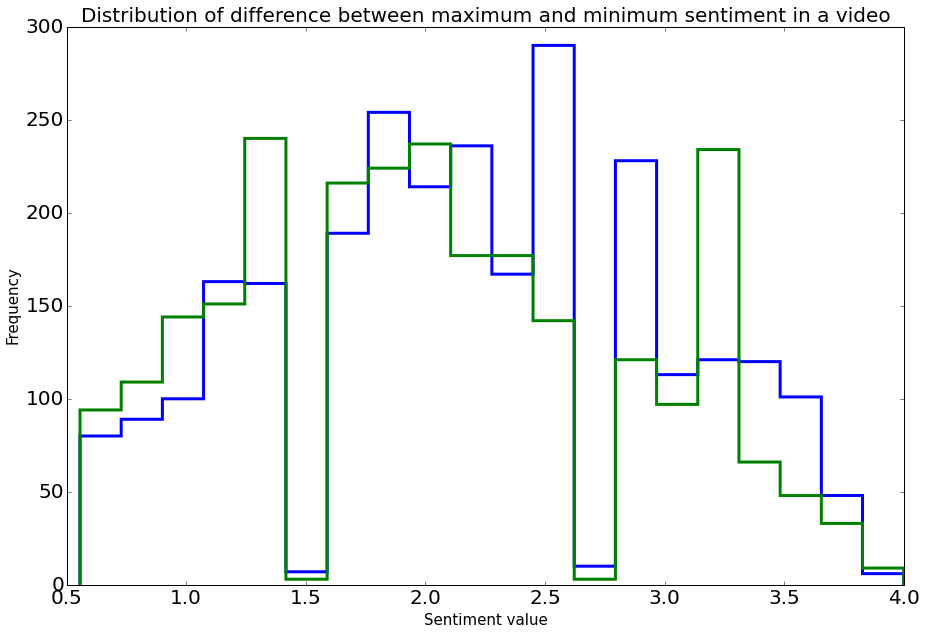

In [180]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
n, bins, patches = plt.hist(diffpop, 20, normed=0,histtype='step', cumulative=False,linewidth = 3.0)
n, bins, patches = plt.hist(diffunpop, 20, normed=0,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of difference between maximum and minimum sentiment in a video", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.show()

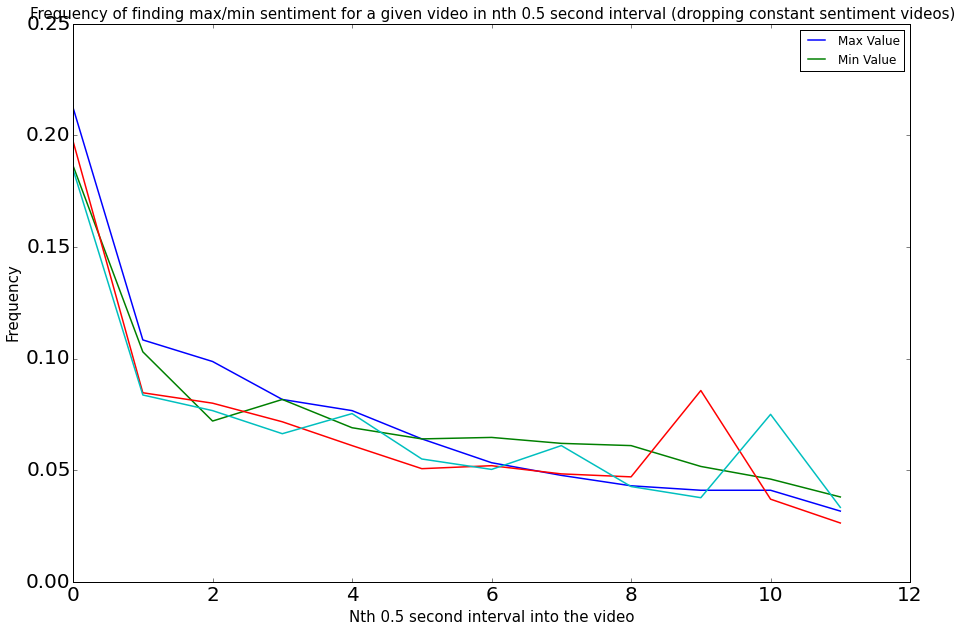

In [155]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.xlabel("Nth 0.5 second interval into the video",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.plot(maxGraph_pop,linewidth = 1.5)
plt.plot(minGraph_pop,linewidth = 1.5)
plt.plot(maxGraph_unpop,linewidth = 1.5)
plt.plot(minGraph_unpop,linewidth = 1.5)

plt.legend(['Max Value', 'Min Value'   
           ])
plt.show()

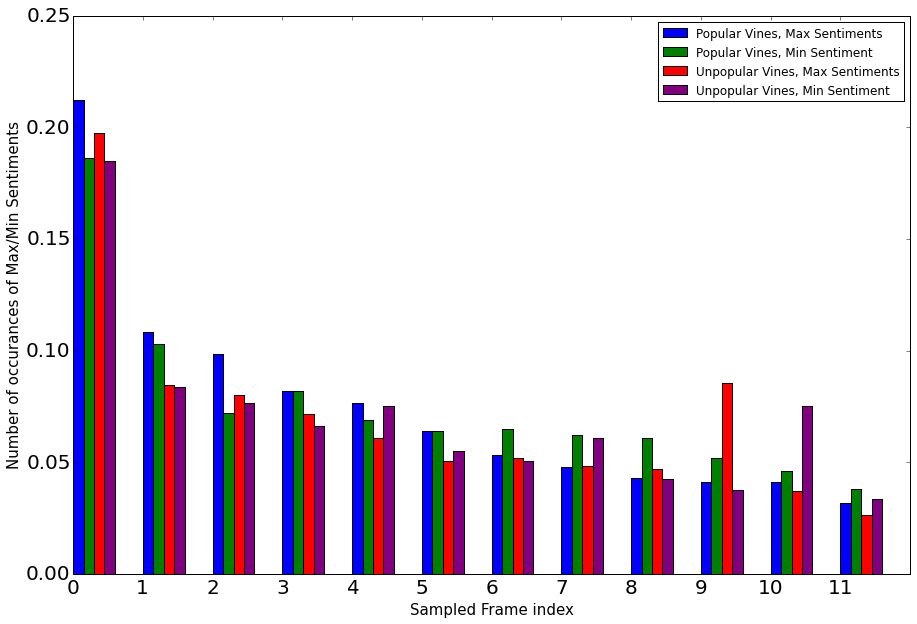

In [179]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ind = np.arange(len(maxGraph_pop)) 
width = 0.15
## the bars
rects1 = ax.bar(ind, maxGraph_pop, width,
                color='b')
rects2 = ax.bar(ind+width, minGraph_pop, width,
                color='g')
rects3 = ax.bar(ind+2*width, maxGraph_unpop, width,
                color='r')
rects4 = ax.bar(ind+3*width, minGraph_unpop, width,
                color='purple')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of occurances of Max/Min Sentiments',fontsize=15)
ax.set_xlabel('Sampled Frame index',fontsize=15)
plt.legend(['Popular Vines, Max Sentiments' ,'Popular Vines, Min Sentiment','Unpopular Vines, Max Sentiments' ,'Unpopular Vines, Min Sentiment'], loc='upper right')
ax.set_xticks(ind )

plt.show()

In [182]:
global_sentiment_matrix = np.concatenate((sampled_pop_senti_matrix ,unpop_senti_matrix) , axis = 0 )

In [183]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(global_sentiment_matrix,i)
    idx,_ = vq(global_sentiment_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)
    
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = global_sentiment_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

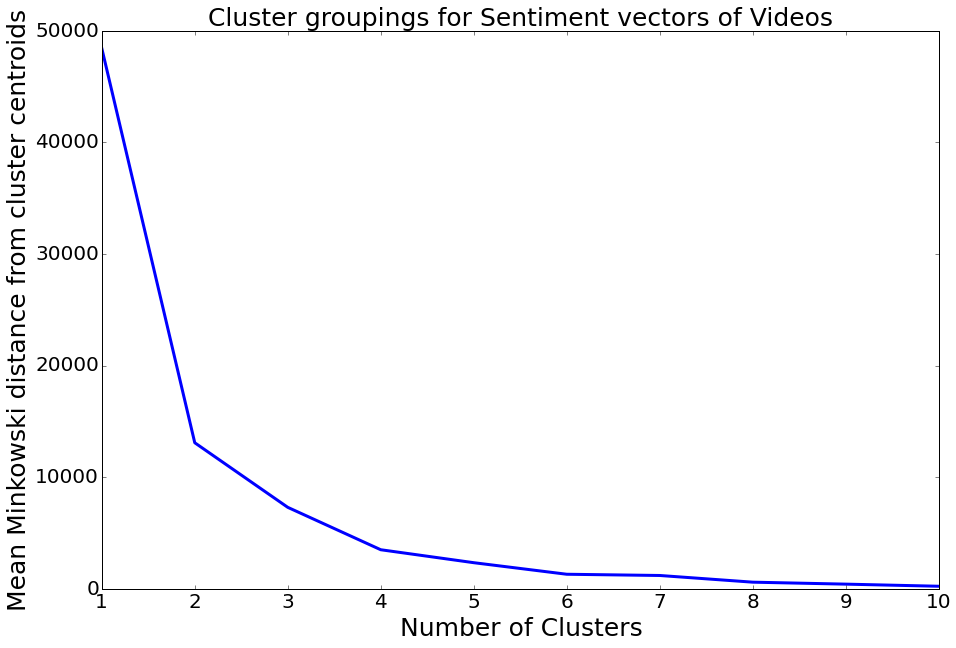

In [197]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.title("Cluster groupings for Sentiment vectors of Videos", fontsize = 25)
plt.show()

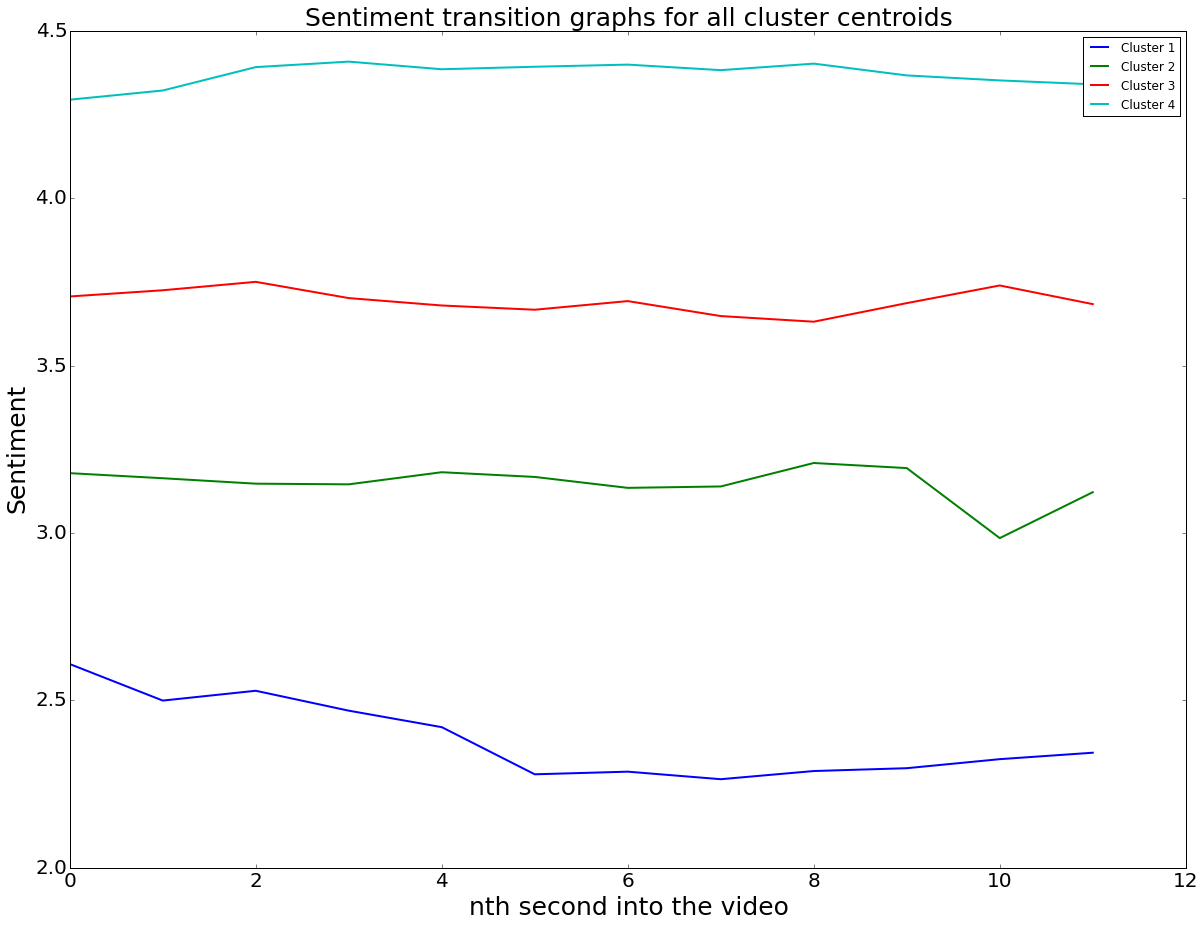

In [198]:
low_dim_centroid_final,_ = kmeans(global_sentiment_matrix,4)
low_dim_idx_final,_ = vq(global_sentiment_matrix,low_dim_centroid_final)

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(low_dim_centroid_final[0], linewidth = 2.0)
plt.plot(low_dim_centroid_final[1], linewidth = 2.0)
plt.plot(low_dim_centroid_final[2], linewidth = 2.0)
plt.plot(low_dim_centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [190]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def findAutocorr(matrix):
    autocorr_matrix = []
    for i in range(matrix.shape[0]):
        autocorr_matrix.append(list(autocorr(matrix[i])))
    return np.asarray(autocorr_matrix)

In [191]:
pop_autocorr_matrix = findAutocorr(sampled_pop_senti_matrix)
unpop_autocorr_matrix = findAutocorr(unpop_senti_matrix)

In [192]:
unpop_auto = np.median(unpop_autocorr_matrix,axis=0)

In [193]:
pop_auto =  np.median(pop_autocorr_matrix,axis=0)

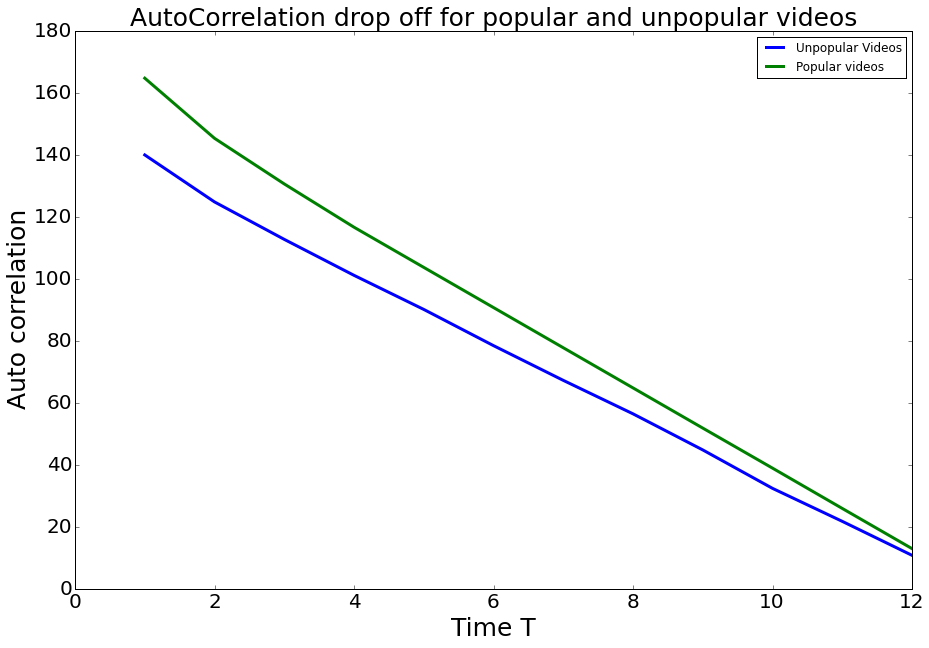

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,13)
plt.plot(x,unpop_auto ,linewidth = 3.0)
plt.plot(x,pop_auto ,linewidth = 3.0)
plt.xlabel("Time T", fontsize = 25)
plt.ylabel("Auto correlation", fontsize = 25)
plt.title("AutoCorrelation drop off for popular and unpopular videos", fontsize = 25)
plt.legend(['Unpopular Videos', 'Popular videos' ]) 
plt.show()